In [177]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix

%pylab inline
import pylab

rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'CMRmap'
rcParams['figure.facecolor'] = 'w'

Populating the interactive namespace from numpy and matplotlib


In [178]:
def scale_img(img):
    '''
    - A utility function to convert image values to [0, 255] range
    '''
    out_img = ((img - np.min(img)) / (np.max(img) - np.min(img)))*255
    return out_img.astype('uint8')

In [179]:
# ref = scale_img(cv2.imread('../../../images/depth_superres/reference.png'))
# ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)

# target =  scale_img(cv2.imread('../../../images/depth_superres/target.png', 0))
# conf =  scale_img(cv2.imread('../../../images/depth_superres/confidence.png', 0))

ref = scale_img(cv2.imread('../../../images/pin_l.jpg'))
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)

target =  scale_img(cv2.imread('../../../images/pin_depth.jpg', 0))
conf =  scale_img(cv2.imread('../../../images/pin_conf.jpg', 0))


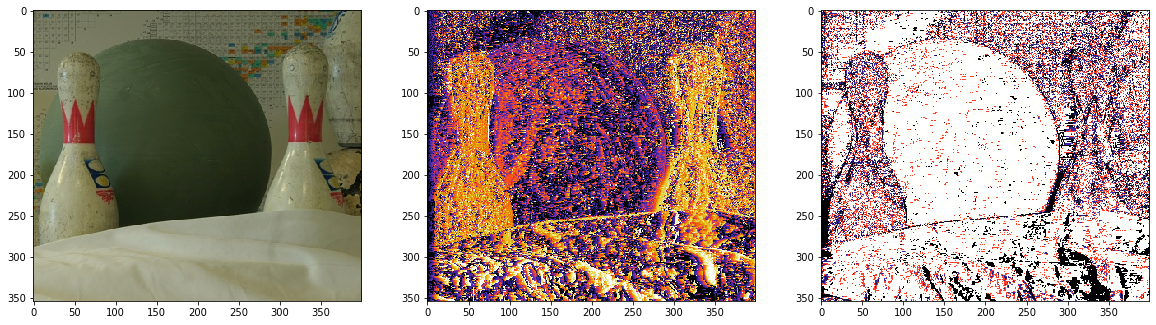

In [180]:
fig = plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.imshow(ref)

plt.subplot(1,3,2)
plt.imshow(target)

plt.subplot(1,3,3)
plt.imshow(conf)

-  We will use openCV RGB to YCrCb
- CSR Matrix = Compressed Row Matrix 
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

In [181]:
 class BilateralHelper:
    '''
    Helpler class for bilateral grid
    BilateralGrid class extend this
    This class implements helper function necessary for grid creation
    '''
    def get_coords(self, im,  sigma_spatial=32, sigma_luma=8, sigma_chroma=8):
        im_yCrCb = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)

        # x_grid, y_grid has same shape (W, H) as input image
        y_grid, x_grid = np.mgrid[:im.shape[0], :im.shape[1]]

        # Spatial Coordinates
        coords_x = (x_grid / sigma_spatial).astype(int)
        coords_y = (y_grid / sigma_spatial).astype(int)

        # Luma Coordinates
        coords_luma = (im_yCrCb[:,:, 0] /sigma_luma).astype(int)

        # Chroma Coordinates
        coords_Cr = (im_yCrCb[:,:, 1] /sigma_chroma).astype(int)

        # Chroma Coordinates
        coords_Cb = (im_yCrCb[:,:, 2] /sigma_chroma).astype(int)

        # 5 Dimensional Coordinates
        coords = np.dstack((coords_x, coords_y, coords_luma, coords_Cr, coords_Cb))

        # Flattening the cordinates
        # Here no of rows = (WxH), i.e: no of pixels
        # no of cols = 5, i.e: (x, y, luma, cr, cb)
        coords = coords.reshape(-1, coords.shape[-1])

        return coords

    def get_hash_coords(self, ndim, coords, hashvec):
        # Hackey Hash Function
        # TODO: How does this hashing works?
        
        hashcoords = coords @ hashvec
        
        # print('HashVec: ', hashvec)
        # print('Coords Shape, Hash Coords Shape: ', coords.shape, hashcoords.shape)

        # hash_uniq: the unique hashes
        # idx_uniq: indices of unique hashed in original array
        # idx_inv: can be used to create original array from hash_uniq
        hash_uniq, idx_uniq, idx_inv =  np.unique(hashcoords, return_index=True, return_inverse=True)

        # Getting unique pixels (This represents vertices)
        uniqcoords = coords[idx_uniq]
        assert hash_uniq.shape[0] == uniqcoords.shape[0], 'No of uniq hashes and no of uniq cords dont match!'

        return hashcoords, hash_uniq, idx_uniq, idx_inv, uniqcoords


    def get_blur_matrices(self, hashvec, uniqcoords, hash_uniq, nvertices, ndim):
        '''
        Creates Blur Matirces
        Number of Blur Matrices = number of dimensions (in our case, 5)

        '''
        def get_valid_idx(valid, candidates):
            # TODO: Make Custom
            # This is just a helper function for creating blur matrices
            """Find which values are present in a list and where they are located"""
            locs = np.searchsorted(valid, candidates)
            # Handle edge case where the candidate is larger than all valid values
            locs = np.clip(locs, 0, len(valid) - 1)
            # Identify which values are actually present
            valid_idx = np.flatnonzero(valid[locs] == candidates)
            locs = locs[valid_idx] 
            return valid_idx, locs
        
        # TODO: More Explanation
        blurs = []
        for d in range(ndim):
            blur = 0
            for offset in (-1, 1):
                offsetvec = np.zeros((1, ndim))
                offsetvec[:, d] = offset
                hash_neighbor = (uniqcoords + offsetvec) @ hashvec
                valid_coord, idx = get_valid_idx(hash_uniq, hash_neighbor)
                blur = blur + csr_matrix((np.ones((len(valid_coord),)),
                                            (valid_coord, idx)),
                                            shape=(nvertices, nvertices))
            blurs.append(blur)

        return blurs





In [182]:
class BilateralGrid(BilateralHelper):

    def __init__(self, im, sigma_spatial=32, sigma_luma=8, sigma_chroma=8):
        
        # Getting 5 dimensional coordinates(npixels x 5)
        coords = self.get_coords(im)
        self.npixels, self.ndim = coords.shape
        print('Number of pixels, dims: ', self.npixels, self.ndim)


        # Creating the hash vector
        hashvec = (255 ** np.arange(self.ndim))
        
        # Hashing the cords
        hashcoords, hash_uniq, idx_uniq, idx_inv, uniqcoords = self.get_hash_coords(self.ndim, coords, hashvec)
        self.nvertices = uniqcoords.shape[0]
        print('Number of vertices: ', self.nvertices)



        # Constructing the sparse Splat matrix to go from pixel -> vertices
        # TODO: How does this procedure work?
        self.S = csr_matrix((np.ones(self.npixels), (idx_inv, np.arange(self.npixels))))
        print('Splat Matrix Shape: ', self.S.shape)

        # Generating The Blur Matrices
        self.blurs = self.get_blur_matrices(hashvec, uniqcoords, hash_uniq, self.nvertices, self.ndim)

    
    def blur(self, x):
        'Blur in bilateral domain with a 1 2 1 filter for each dim'
        blur_output = 2 * self.ndim * x
        for blur in self.blurs:
            blur_output += blur @ x
        return blur_output

    def splat(self, x):
        return self.S @ x

    def slice(self, x):
        return self.S.T @ x

    def apply_filter(self, x):
        '''
        This function applies the created bilateral filter to given input
        '''
        out = (self.S.T @ self.blur(self.S @ x) )
        out = out / (self.S.T @ self.blur(self.S @ np.ones_like(x)))
        return out



In [183]:
%%time
grid = BilateralGrid(ref)

Number of pixels, dims:  141600 5
Number of vertices:  4264
Splat Matrix Shape:  (4264, 141600)
CPU times: user 141 ms, sys: 39.9 ms, total: 181 ms
Wall time: 114 ms


In [184]:
%%time
# Normalizing

# t =   target.reshape(-1, 1).astype(double) / (pow(2,16)-1) # Why are we doing this?
# c =   conf.reshape(-1, 1).astype(double) / (pow(2,16)-1)

t =   target.reshape(-1, 1).astype(double) / 255.0
c =   conf.reshape(-1, 1).astype(double) / 255.0

tc_filt = grid.apply_filter(t * c)
c_filt = grid.apply_filter(c)
output = (tc_filt / c_filt).reshape(ref.shape[:2])

CPU times: user 19.7 ms, sys: 0 ns, total: 19.7 ms
Wall time: 17.8 ms


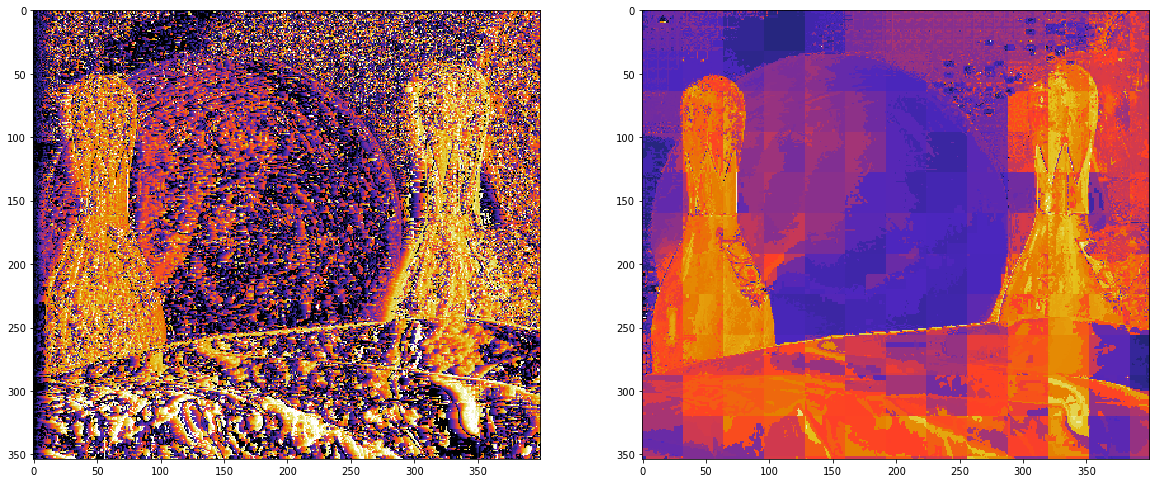

In [185]:
fig = plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.imshow(target)

plt.subplot(1,2,2)
plt.imshow(output)

In [186]:
# TODO: Restructure this completely

from scipy.sparse import diags
from scipy.sparse.linalg import cg

def bistochastize(grid, maxiter=10):
    """Compute diagonal matrices to bistochastize a bilateral grid"""
    m = grid.splat(np.ones(grid.npixels))
    n = np.ones(grid.nvertices)
    for i in range(maxiter):
        n = np.sqrt(n * m / grid.blur(n))
    # Correct m to satisfy the assumption of bistochastization regardless
    # of how many iterations have been run.
    m = n * grid.blur(n)
    Dm = diags(m, 0)
    Dn = diags(n, 0)
    return Dn, Dm

class BilateralSolver(object):
    def __init__(self, grid, params):
        self.grid = grid
        self.params = params
        self.Dn, self.Dm = bistochastize(grid)
    
    def solve(self, x, w):
        # Check that w is a vector or a nx1 matrix
        if w.ndim == 2:
            assert(w.shape[1] == 1)
        elif w.dim == 1:
            w = w.reshape(w.shape[0], 1)
        A_smooth = (self.Dm - self.Dn.dot(self.grid.blur(self.Dn)))
        w_splat = self.grid.splat(w)+1
        A_data = diags(w_splat[:,0], 0)
        A = self.params["lam"] * A_smooth + A_data
        xw = x * w
        b = self.grid.splat(xw)
        # Use simple Jacobi preconditioner
        A_diag = np.maximum(A.diagonal(), self.params["A_diag_min"])
        M = diags(1 / A_diag, 0)
        # Flat initialization
        y0 = self.grid.splat(xw) / w_splat
        yhat = np.empty_like(y0)
        for d in range(x.shape[-1]):
            yhat[..., d], info = cg(A, b[..., d], x0=y0[..., d], M=M, maxiter=self.params["cg_maxiter"], tol=self.params["cg_tol"])
        xhat = self.grid.slice(yhat)
        return xhat

In [187]:
bs_params = {
    'lam': 128, # The strength of the smoothness parameter
    'A_diag_min': 1e-5, # Clamp the diagonal of the A diagonal in the Jacobi preconditioner.
    'cg_tol': 1e-5, # The tolerance on the convergence in PCG
    'cg_maxiter': 40 # The number of PCG iterations
}

In [188]:
output_solver = BilateralSolver(grid, bs_params).solve(t, c).reshape(ref.shape[:2])

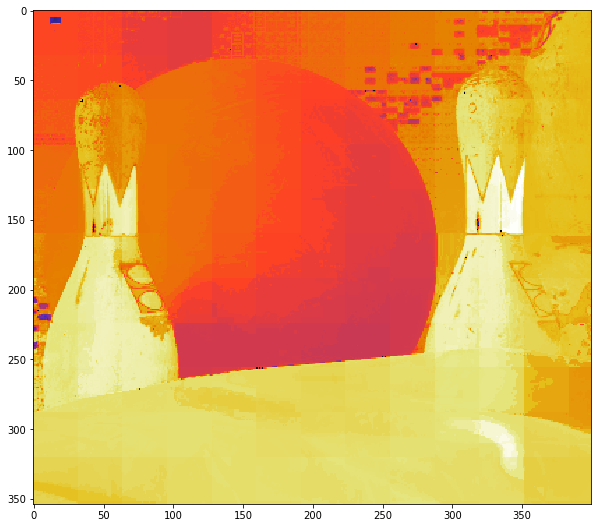

In [191]:
fig = plt.figure(figsize=(10,10))
plt.imshow(output_solver)